# Merge the PC field of two data bases.

In [14]:

# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from scipy.stats import t, ttest_1samp
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb

In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'

# birds = [
#    os.path.basename(bird)
#    for bird in sorted(glob.glob(os.path.join(rootPath+dataPath, "*")), key=os.path.getmtime, reverse=True)
#    if (os.path.isdir(bird))]
    
birds = ['ZF4F', 'ZF5M', 'ZF6M', 'ZF7F' ]

# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [4]:
# Load the two data bases
inPath = rootPath+dataPath+'HerminaDataBase.pkl'
fileIn = open(inPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

# Load the two data bases
inPath = rootPath+dataPath+'HerminaDataBasePCPOS.pkl'
fileIn = open(inPath,"rb")
dfDataBasePOS = pk.load(fileIn)
pcKDEPOS = pk.load(fileIn)
fileIn.close()

In [5]:
dfDataBasePOS['PC']=dfDataBase['PC']

In [6]:
# Number of Units
unitNames = np.unique(dfDataBasePOS['site']+'_'+ dfDataBasePOS['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBasePOS['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBasePOS['stim'][dfDataBasePOS['site']+'_'+ dfDataBasePOS['unit'] == unit]))
    # Select only Units with 110 stimuli (for now) or 97  if NW
    if (nstimsUnit[unit] == 110):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)


187


In [7]:
def naiveBayes(unitChoice, plotFlg = False, usingAllCombos = False, code='z'):
    # naiveBayes runs a guassian classifier for call types using the responses in the units in the list unitChoice
    # For now it uses the zscore in the dfDataBasePOS
    
    # Number of units
    numUnits = len(unitChoice)
    
    # Number of PCs (for PC code)
    nPCs = dfDataBasePOS['PC'][0].shape[0]
    
    if (nPCs != dfDataBasePOS['PCPOS'][0].shape[0]):
        print('Error - different number of PCs in pos vs non')
    
    # Find the unique stims played for the chosen unit
    unitIndexDict = dict()
    unitIndexLen = []
    stimList = []
    for unit in unitChoice:   
        unitIndex = dfDataBasePOS.index[dfDataBasePOS['site']+'_'+ dfDataBasePOS['unit'] == unit]
        unitIndexDict[unit] = unitIndex
        unitIndexLen.append(len(unitIndex))
        stimList.extend(list(dfDataBasePOS['stim'][unitIndex].array))
    
    stimNames = np.unique(stimList)
    
    # Generate ensemble responses  for the units in unitChoice

    # Training Trials
    rowListList = []
    totTrials = 0

    # Testing Trials
    rowListListTest = []
    totTestTrials = 0

    for stim in stimNames:
        goodStim = 2    # This means that we have at least two trials for each stim for all units
        
        # Check to see if we have enough trials for all units for this stim
        for unit in unitChoice:
            unitIndex = unitIndexDict[unit]
            unitIndexStim = [ind for ind in unitIndex if dfDataBasePOS['stim'][ind] == stim]
            if len(unitIndexStim) == 0:
                goodStim = 0
                print('Stim ', stim, 'has no response for unit', unit, '. Skipping')
                break
            elif len(unitIndexStim) == 1:
                goodStim = 1
            
        # If so continue
        if goodStim > 0 :
            rowList2Cat = []
            rowList2CatLen = []
            for unit in unitChoice:
                unitIndex = unitIndexDict[unit]
                unitIndexStim = [ind for ind in unitIndex if dfDataBasePOS['stim'][ind] == stim]
                rowList2Cat.append(unitIndexStim)
                rowList2CatLen.append(len(unitIndexStim))
            
            if goodStim > 1 :  # Use one of the responses for the test set
                listTest = []
                for iunit, unit in enumerate(unitChoice):
                    rowchosen = np.random.choice(rowList2Cat[iunit], 1, replace=False)
                    listTest.append(rowchosen[0])
                    rowList2Cat[iunit].remove(rowchosen)
                    rowList2CatLen[iunit] = len(rowList2Cat[iunit])
                rowListListTest.append(listTest)
                totTestTrials +=1
            
            if usingAllCombos:
                numSamp = np.prod(rowList2CatLen)
                totTrials += numSamp
            
                list_of_lists = []

                indUnit = np.zeros((numUnits,), dtype=int)
                indUnit[0] = -1
            
                for i in range(numSamp):
                    for iunit, unit in enumerate(unitChoice):
                        indUnit[iunit] += 1
                        if (indUnit[iunit] >= len(rowList2Cat[iunit]) ):
                            indUnit[iunit] = 0
                        else: 
                            break
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        trialList.append(rowList2Cat[iunit][indUnit[iunit]])
                
                    list_of_lists.append(trialList)
            else:
                numSamp = np.max(rowList2CatLen)
                totTrials += numSamp
                    
                list_of_lists = []
                for i in range(numSamp):
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        if i < len(rowList2Cat[iunit]):
                            trialList.append(rowList2Cat[iunit][i])
                        else:
                            trialList.append(np.random.choice(rowList2Cat[iunit], 1, replace=False)[0])
                    list_of_lists.append(trialList)
        
            rowListList.extend(list_of_lists)

    print('Total number of trials:', totTrials)
    print('Total number of test trials:', totTestTrials)
    
    # Make X (neural code), Y (call type)
    if code == 'z':
        Xfit = np.zeros((totTrials, numUnits*1))
        Xtest = np.zeros((totTestTrials, numUnits*1))
    elif code == 'PC':
        Xfit = np.zeros((totTrials, numUnits*(1+nPCs)))
        XfitPOS = np.zeros((totTrials, numUnits*(1+nPCs)))
        Xtest = np.zeros((totTestTrials, numUnits*(1+nPCs)))
        XtestPOS = np.zeros((totTrials, numUnits*(1+nPCs)))
        
    Yfit = []
    for irow,rowList in enumerate(rowListList):
        if code == 'z':
            Xfit[irow,:] = dfDataBasePOS['z'][rowList].array
        elif code == 'PC':
            Xfit[irow,:] = np.hstack([np.hstack((dfDataBasePOS['z'][ind], dfDataBasePOS['PC'][ind])) for ind in rowList])
            XfitPOS[irow,:] = np.hstack([np.hstack((dfDataBasePOS['z'][ind], dfDataBasePOS['PCPOS'][ind])) for ind in rowList])
        
        Yfit.append(np.unique(dfDataBasePOS['call'][rowList].array)[0])
    Yfit = np.array(Yfit)

    
    Ytest = []
    for irow,rowList in enumerate(rowListListTest):
        if code == 'z':
            Xtest[irow,:] = dfDataBasePOS['z'][rowList].array
        elif code == 'PC':
            Xtest[irow,:] = np.hstack([np.hstack((dfDataBasePOS['z'][ind], dfDataBasePOS['PC'][ind])) for ind in rowList])
            XtestPOS[irow,:] = np.hstack([np.hstack((dfDataBasePOS['z'][ind], dfDataBasePOS['PCPOS'][ind])) for ind in rowList])
        Ytest.append(np.unique(dfDataBasePOS['call'][rowList].array)[0])
    
    Ytest = np.array(Ytest)
    
    
    # Fit and test the classifier clf
    nClasses = len(np.unique(Yfit))

    clf = GaussianNB(priors=np.ones((nClasses,))/nClasses)
    clf.fit(Xfit,Yfit)
    
    if code == 'PC':
        clfPOS = GaussianNB(priors=np.ones((nClasses,))/nClasses)
        clfPOS.fit(XfitPOS,Yfit)
        

    probTest = clf.predict_proba(Xtest)

    # Make a confusion matrix
    confMat = np.zeros((nClasses,nClasses))
    testsPerClass = np.zeros((nClasses,))

    for i,y in enumerate(Ytest):
        classID = np.argwhere(clf.classes_ == y)
        testsPerClass[classID] += 1    
        confMat[classID,:] += probTest[i]
    
    # The confusion matrix is not normalized so that we can average it correctly later on.. 
    #for i in range(nClasses):
    #    confMat[i,:] /= testsPerClass[i]
    
    # Print percent correct classification by taking average of diagonal of confusion matrix.
    sumCorrect = np.trace(confMat)
    sumTest = np.sum(testsPerClass)
    pcc = 100.0*(sumCorrect/sumTest)
    print('PCC %.0f %%' % (pcc))
    
    if code == 'PC':
        probTestPOS = clfPOS.predict_proba(XtestPOS)
        # Make a confusion matrix
        confMatPOS = np.zeros((nClasses,nClasses))
        testsPerClassPOS = np.zeros((nClasses,))

        for i,y in enumerate(Ytest):
            classID = np.argwhere(clf.classes_ == y)
            testsPerClassPOS[classID] += 1    
            confMatPOS[classID,:] += probTestPOS[i]
    
        # The confusion matrix is not normalized so that we can average it correctly later on.. 
        #for i in range(nClasses):
        #    confMat[i,:] /= testsPerClass[i]
    
        # Print percent correct classification by taking average of diagonal of confusion matrix.
        sumCorrect = np.trace(confMatPOS)
        sumTest = np.sum(testsPerClassPOS)
        pccPOS = 100.0*(sumCorrect/sumTest)
        print('PCC POS%.0f %%' % (pccPOS))
    else:
        pccPos = pcc
        confMatPOS = confMat
        testsPerClassPOS = testsPerClass
    
    if plotFlg:
        # Normalize confMat for display
        confMatNorm = np.zeros((nClasses,nClasses))
        for i in range(nClasses):
            if testsPerClass[i] > 0 :
                confMatNorm[i,:] = confMat[i,:]/testsPerClass[i]
                
        # Display comfusion matrix
        cmap='viridis'
        fig, ax = plt.subplots()
        im_ = ax.imshow(confMat*100.0, interpolation='nearest', cmap=cmap)

        fig.colorbar(im_, ax=ax)
        ax.set(xticks=np.arange(nClasses),
               yticks=np.arange(nClasses),
               xticklabels=clf.classes_,
               yticklabels=clf.classes_,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='PPC %.0f %%' % (pcc))
    
    return pcc, confMat, testsPerClass, pccPOS, confMatPOS, testsPerClassPOS



In [11]:
# Loop through all neurons and PC 
numUnits = 1
code = 'PC'


# Choose random units
# unitChoice = np.random.choice(unitNamesFull, numUnits, replace=False)
# comb(nunitsFull, 3)
pcc = np.zeros((nunitsFull,))
confMatTot = np.zeros((ncalls, ncalls))
confMatCount = np.zeros((ncalls,))

pccPOS = np.zeros((nunitsFull,))
confMatTotPOS = np.zeros((ncalls, ncalls))
confMatCountPOS = np.zeros((ncalls,))

for i,unit in enumerate(unitNamesFull):
    unitChoice = [unit]
    pcc[i], confMat, testsPerClass, pccPOS[i], confMatPOS, testsPerClassPOS  = naiveBayes(unitChoice, plotFlg = False, code = code)

    confMatTot = np.add(confMatTot, confMat)
    confMatCount += testsPerClass
    
    confMatTotPOS = np.add(confMatTotPOS, confMatPOS)
    confMatCountPOS += testsPerClassPOS

for i in range(ncalls):
    if confMatCount[i] != confMatCountPOS[i] :
        print('Error: missmatch between data bases for', callNames[i], confMatCount[i], 'vs', confMatCountPos[i]  )
    if confMatCount[i] > 0:
        confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]
        confMatTotPOS[i,:] = confMatTotPOS[i,:]/confMatCountPOS[i]

# this is to save the results of pcc for chosing only single neurons with pcc > 13
if ((numUnits == 1) & (code == 'PC')):
    # save the PC and Confusion matrices data base
    outPath = rootPath+dataPath+'HerminaDataBase1UnitPCPOS.pkl'
    fileOut = open(outPath,"wb")
    pk.dump(unitNamesFull, fileOut)
    pk.dump(confMatTot, fileOut)
    pk.dump(pcc, fileOut)
    pk.dump(confMatTotPOS, fileOut)
    pk.dump(pccPOS, fileOut)
    fileOut.close()

Total number of trials: 284
Total number of test trials: 110
PCC 15 %
PCC POS13 %
Total number of trials: 297
Total number of test trials: 109
PCC 10 %
PCC POS10 %
Total number of trials: 333
Total number of test trials: 110
PCC 15 %
PCC POS14 %
Total number of trials: 307
Total number of test trials: 110
PCC 13 %
PCC POS12 %
Total number of trials: 297
Total number of test trials: 109
PCC 15 %
PCC POS14 %
Total number of trials: 308
Total number of test trials: 110
PCC 15 %
PCC POS15 %
Total number of trials: 328
Total number of test trials: 110
PCC 13 %
PCC POS12 %
Total number of trials: 401
Total number of test trials: 110
PCC 15 %
PCC POS15 %
Total number of trials: 320
Total number of test trials: 109
PCC 12 %
PCC POS12 %
Total number of trials: 287
Total number of test trials: 110
PCC 8 %
PCC POS9 %
Total number of trials: 302
Total number of test trials: 110
PCC 13 %
PCC POS13 %
Total number of trials: 329
Total number of test trials: 110
PCC 18 %
PCC POS15 %
Total number of tr

PCC 12 %
PCC POS10 %
Total number of trials: 137
Total number of test trials: 74
PCC 7 %
PCC POS7 %
Total number of trials: 769
Total number of test trials: 110
PCC 9 %
PCC POS9 %
Total number of trials: 163
Total number of test trials: 106
PCC 11 %
PCC POS10 %
Total number of trials: 384
Total number of test trials: 110
PCC 24 %
PCC POS20 %
Total number of trials: 267
Total number of test trials: 107
PCC 11 %
PCC POS11 %
Total number of trials: 127
Total number of test trials: 84
PCC 13 %
PCC POS12 %
Total number of trials: 870
Total number of test trials: 110
PCC 12 %
PCC POS10 %
Total number of trials: 447
Total number of test trials: 110
PCC 11 %
PCC POS11 %
Total number of trials: 780
Total number of test trials: 110
PCC 15 %
PCC POS13 %
Total number of trials: 877
Total number of test trials: 110
PCC 13 %
PCC POS13 %
Total number of trials: 136
Total number of test trials: 76
PCC 8 %
PCC POS9 %
Total number of trials: 615
Total number of test trials: 110
PCC 10 %
PCC POS10 %
Tota

In [12]:
# Re read the results file
inPath = rootPath+dataPath+'HerminaDataBase1UnitPCPOS.pkl'
fileIn = open(inPath,"rb")
unitNamesFull = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pcc = pk.load(fileIn)
confMatTotPOS = pk.load(fileIn)
pccPOS = pk.load(fileIn)
fileIn.close()

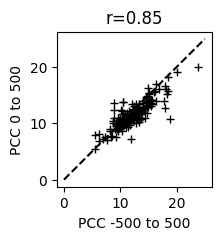

In [13]:
fig = plt.figure(figsize=(2,3), dpi=100)

# Compare pcc
plt.plot(pcc, pccPOS, 'k+')
plt.plot([0, 25], [0, 25], 'k--')
plt.xlim((0,20))
plt.ylim((0,20))
plt.xlabel('PCC -500 to 500')
plt.ylabel('PCC 0 to 500')
plt.axis('square')

rval = np.corrcoef(pcc, pccPOS)
plt.title(f'r={rval[0,1]:.2}')

plt.savefig('/Users/frederictheunissen/Desktop/pccVSpccPOS.eps')


In [15]:
tval, pval = ttest_1samp(pcc-pccPOS, 0)
meandiff = np.mean(pcc-pccPOS)
meandiffper = np.mean((pcc-pccPOS)/pcc)
df = len(pcc)-1
print(f'Diff = {meandiff:.2f} Per Diff = {meandiffper:.2} t({df})={tval:.3f} p = {pval:.4f}')

Diff = 0.58 Per Diff = 0.034 t(186)=5.380 p = 0.0000
